## Part 2a: generate disv properties

In [1]:
import sys, json, os ## Org
import rasterio, flopy ## Org
import numpy as np ## Org
import matplotlib.pyplot as plt ## Org
import geopandas as gpd ## Org
from mf6Voronoi.meshProperties import meshShape ## Org
from shapely.geometry import MultiLineString ## Org
from mf6Voronoi.tools.cellWork import getLayCellElevTupleFromRaster, getLayCellElevTupleFromElev ## Org

In [2]:
# open the json file
with open('../json/disvDict.json') as file: ## Org
    gridProps = json.load(file) ## Org

In [3]:
cell2d = gridProps['cell2d']           #cellid, cell centroid xy, vertex number and vertex id list
vertices = gridProps['vertices']       #vertex id and xy coordinates
ncpl = gridProps['ncpl']               #number of cells per layer
nvert = gridProps['nvert']             #number of verts
centroids=gridProps['centroids']       #cell centroids xy 

## Part 2b: Model construction and simulation

In [4]:
#Extract dem values for each centroid of the voronois
src = rasterio.open('../rst/topoWgs12N.tif') ## Org
elevation=[x for x in src.sample(centroids)] ## Org

In [5]:
nlay = 15 ## Org

mtop=np.array([elev[0] for i,elev in enumerate(elevation)]) ## Org
zbot=np.zeros((nlay,ncpl)) ## Org


AcuifInf_Bottom = 1300 ## Org
zbot[0,] = AcuifInf_Bottom + (0.95 * (mtop - AcuifInf_Bottom)) ## Org
zbot[1,] = AcuifInf_Bottom + (0.90 * (mtop - AcuifInf_Bottom)) ## Org
zbot[2,] = AcuifInf_Bottom + (0.85 * (mtop - AcuifInf_Bottom)) ## Org
zbot[3,] = AcuifInf_Bottom + (0.80 * (mtop - AcuifInf_Bottom)) ## Org
zbot[4,] = AcuifInf_Bottom + (0.75 * (mtop - AcuifInf_Bottom)) ## Org
zbot[5,] = AcuifInf_Bottom + (0.70 * (mtop - AcuifInf_Bottom)) ## Org
zbot[6,] = AcuifInf_Bottom + (0.65 * (mtop - AcuifInf_Bottom)) ## Org
zbot[7,] = AcuifInf_Bottom + (0.60 * (mtop - AcuifInf_Bottom)) ## Org
zbot[8,] = AcuifInf_Bottom + (0.55 * (mtop - AcuifInf_Bottom)) ## Org
zbot[9,] = AcuifInf_Bottom + (0.50 * (mtop - AcuifInf_Bottom)) ## Org
zbot[10,] = AcuifInf_Bottom + (0.45 * (mtop - AcuifInf_Bottom)) ## Org
zbot[11,] = AcuifInf_Bottom + (0.40 * (mtop - AcuifInf_Bottom)) ## Org
zbot[12,] = AcuifInf_Bottom + (0.35 * (mtop - AcuifInf_Bottom)) ## Org
zbot[13,] = AcuifInf_Bottom + (0.2 * (mtop - AcuifInf_Bottom)) ## Org
zbot[14,] = AcuifInf_Bottom ## Org

### Create simulation and model

In [6]:
# create simulation
simName = 'mf6Sim' ## Org
modelName = 'mf6Model' ## Org
modelWs = '../modelFiles' ## Org
sim = flopy.mf6.MFSimulation(sim_name=modelName, version='mf6', ## Org
                             exe_name='../bin/mf6.exe', 
                             continue_=True, ## <=== updated
                             sim_ws=modelWs) ## Org

In [7]:
# create tdis package
tdis_rc = [(1.0, 1, 1.0)] + [(86400*365*4, 1, 1.0) for level in range(5)] ## Org
print(tdis_rc[:3]) ## Org

tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='SECONDS', ## Org
                             perioddata=tdis_rc, ## Org
                            nper=6) ## Org
 

[(1.0, 1, 1.0), (126144000, 1, 1.0), (126144000, 1, 1.0)]


In [8]:
# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, ## Org
                           modelname=modelName, ## Org
                           save_flows=True, ## Org
                           newtonoptions="NEWTON UNDER_RELAXATION") ## Org

In [9]:
# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, ## Org
                           complexity='COMPLEX', ## Org
                           outer_maximum=150, ## Org
                           inner_maximum=50, ## Org
                           outer_dvclose=0.1, ## Org
                           inner_dvclose=0.0001, ## Org
                           backtracking_number=20, ## Org
                           linear_acceleration='BICGSTAB') ## Org
sim.register_ims_package(ims,[modelName]) ## Org

In [10]:
# disv
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, ## Org
                                top=mtop, botm=zbot, ## Org
                                nvert=nvert, vertices=vertices, ## Org
                                cell2d=cell2d) ## Org

<Axes: title={'center': 'top'}>

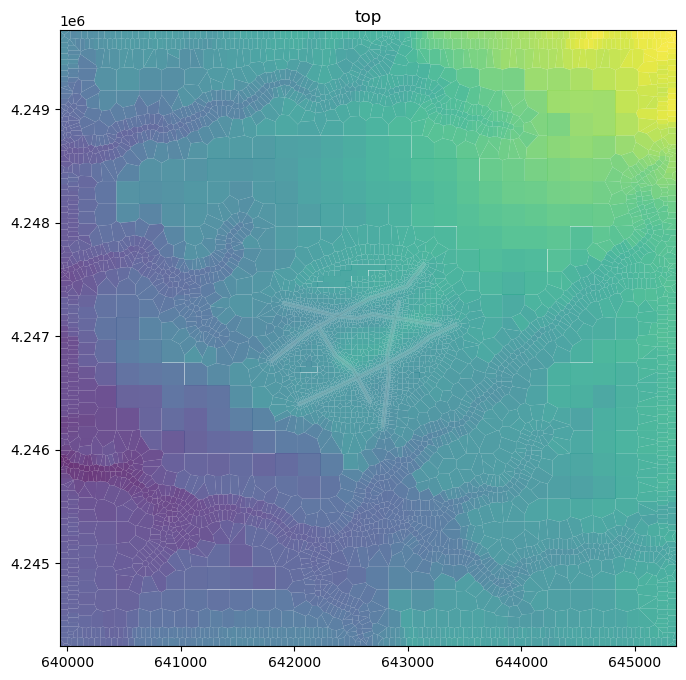

In [11]:
disv.top.plot(figsize=(12,8), alpha=0.8) ## Org

In [12]:
crossSection = gpd.read_file('../shp/crossSection.shp') ## Org
sectionLine =list(crossSection.iloc[0].geometry.coords) ## Org
sectionLine ## Org

[(642484.0798515758, 4248532.184260054),
 (642438.4784573925, 4245577.213916981)]

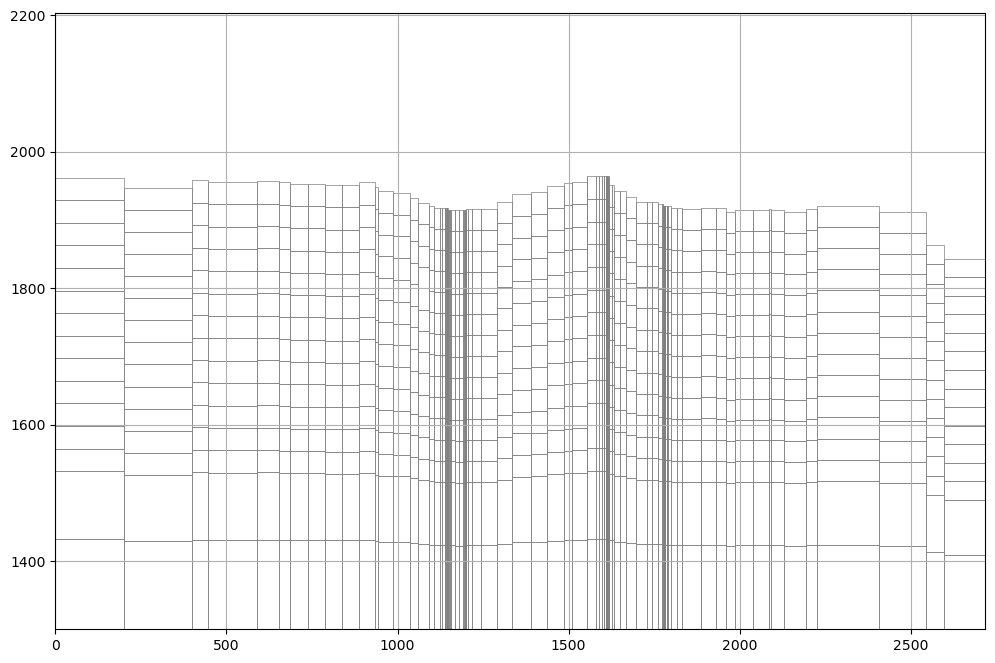

In [13]:

fig, ax = plt.subplots(figsize=(12,8)) ## Org
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine}) ## Org
linecollection = modelxsect.plot_grid(lw=0.5) ## Org
ax.grid() ## Org

In [14]:
# initial conditions

ic = flopy.mf6.ModflowGwfic(gwf, #<==== Uncommented
                            strt=np.stack([mtop for i in range(nlay)])) ## Org
#headsInitial = np.load('../npy/headCalibInitial.npy') ## Org <== Commented
#ic = flopy.mf6.ModflowGwfic(gwf, strt=headsInitial) ## Org <=== Commented

In [15]:
ncplOnes = np.ones(ncpl) # <===== Inserted
Kx =[4E-4] + [7E-7 for x in range(6)] + [3E-7 for x in range(6)] + [1E-7 for x in range(nlay - 13)] ## Org
Kx = [kValue*ncplOnes for kValue in Kx] # <===== Inserted
Kx = np.hstack(Kx) # <===== Inserted

# Kx =[4E-4] + [7E-7 for x in range(4)] + [3E-7 for x in range(4)] + [1E-7 for x in range(nlay - 9)] ## Org
icelltype = [1 for x in range(10)] + [0 for x in range(nlay - 10)] ## Org


# Define intersection object # <===== Inserted
interIx = flopy.utils.gridintersect.GridIntersect(gwf.modelgrid) # <===== Inserted

faultDf = gpd.read_file('../shp/faults_v2.shp') # <===== Inserted

# for faults <==== Inserted
for index, row in faultDf.iterrows(): # <===== Inserted
    cellids = interIx.intersect(row.geometry).cellids # <===== Inserted
    cellidsListLy1_end = [list(cellids+ncpl*lay) for lay in range(1,gwf.modelgrid.nlay)] # <===== Inserted
    Kx[cellidsListLy1_end] = 9e-7 # <===== Inserted

# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, ## Org
                              save_specific_discharge=True, ## Org
                              icelltype=icelltype, ## Org
                              k=Kx, ## Org
                            #   k33=np.array(Kx)/10) ## Org
                              k33 = Kx) ## Org

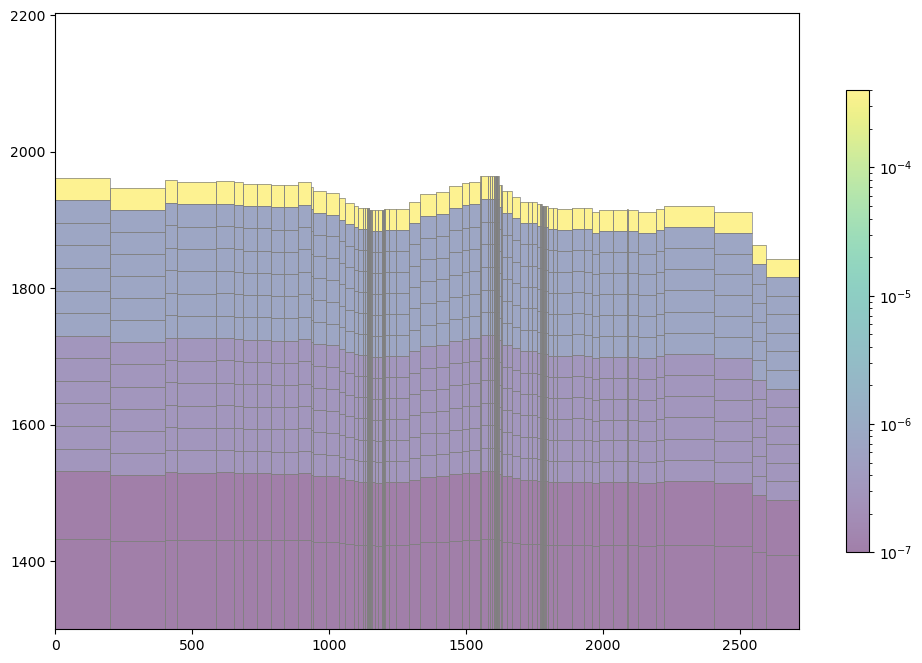

In [16]:
#plot cross section
import matplotlib.colors as mcolors # <===== Inserted
crossSection = gpd.read_file('../shp/crossSection.shp') # <===== Inserted
sectionLine =list(crossSection.iloc[0].geometry.coords) # <===== Inserted

fig, ax = plt.subplots(figsize=(12,8)) # <===== Inserted
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine}) # <===== Inserted
linecollection = modelxsect.plot_array(npf.k.array, 
                                       alpha=0.5, 
                                       norm=mcolors.LogNorm(vmin=Kx.min(), 
                                                            vmax=Kx.max()))  # <===== Inserted
modelxsect.plot_grid(lw=0.5) # <===== Inserted 

plt.colorbar(linecollection, shrink=0.75) # <===== Inserted

In [17]:
# define storage and transient stress periods
sto = flopy.mf6.ModflowGwfsto(gwf, ## Org
                              iconvert=1, ## Org
                              steady_state={ ## Org
                                0:True, ## Org
                              },
                              transient={
                                  1:True, ## Org
                                  2:True, ## Org
                                  3:True, ## Org
                                  4:True, ## Org
                                  5:True, ## Org
                              },
                              ss=1e-06, ## Org
                              sy=0.001, ## Org
                              ) ## Org

#### Working with rechage, evapotranspiration

In [18]:
rchr = 0.2/365/86400 ## Org
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rchr) ## Org
evtr = 1.2/365/86400 ## Org
evt = flopy.mf6.ModflowGwfevta(gwf,ievt=1,surface=mtop,rate=evtr,depth=1.0) ## Org

### Definition of the intersect object
For the manipulation of spatial data to determine hydraulic parameters or boundary conditions

In [19]:
# Define intersection object
interIx = flopy.utils.gridintersect.GridIntersect(gwf.modelgrid) ## Org

In [20]:
#river package
layCellTupleList, cellElevList = getLayCellElevTupleFromRaster(gwf,interIx,'../rst/topoWgs12N.tif','../shp/river_basin.shp') ## Org
riverSpd = {} ## Org
riverSpd[0] = [] ## Org
for index, layCellTuple in enumerate(layCellTupleList): ## Org
    riverSpd[0].append([layCellTuple,cellElevList[index],0.01,'Drain']) # <===== Inserted

In [21]:
import copy ## Org
#for yr 4 
riverSpd[1] = copy.copy(riverSpd[0]) ## Org
layCellTupleList, cellElevList = getLayCellElevTupleFromRaster(gwf, ## Org
                                                               interIx, ## Org
                                                               '../rst/minePlan/pitElevYr04.tif', ## Org
                                                               '../shp/minePlan/pitShell.shp') ## Org
for index, layCellTuple in enumerate(layCellTupleList): ## Org
    riverSpd[1].append([layCellTuple,cellElevList[index],0.011, 'Pit']) # <===== Inserted

#for yr 8 
riverSpd[2] = copy.copy(riverSpd[0]) ## Org
layCellTupleList, cellElevList = getLayCellElevTupleFromRaster(gwf, ## Org
                                                               interIx, ## Org
                                                               '../rst/minePlan/pitElevYr08.tif', ## Org
                                                               '../shp/minePlan/pitShell.shp') ## Org
for index, layCellTuple in enumerate(layCellTupleList): ## Org
    riverSpd[2].append([layCellTuple,cellElevList[index],0.012, 'Pit']) # <===== Inserted

#for yr 12 
riverSpd[3] = copy.copy(riverSpd[0]) ## Org
layCellTupleList, cellElevList = getLayCellElevTupleFromRaster(gwf, ## Org
                                                               interIx, ## Org
                                                               '../rst/minePlan/pitElevYr12.tif', ## Org
                                                               '../shp/minePlan/pitShell.shp') ## Org
for index, layCellTuple in enumerate(layCellTupleList): ## Org
    riverSpd[3].append([layCellTuple,cellElevList[index],0.013, 'Pit']) # <===== Inserted

#for yr 16 
riverSpd[4] = copy.copy(riverSpd[0]) ## Org
layCellTupleList, cellElevList = getLayCellElevTupleFromRaster(gwf, ## Org
                                                               interIx, ## Org
                                                               '../rst/minePlan/pitElevYr16.tif', ## Org
                                                               '../shp/minePlan/pitShell.shp') ## Org
for index, layCellTuple in enumerate(layCellTupleList): ## Org
    riverSpd[4].append([layCellTuple,cellElevList[index],0.014, 'Pit']) # <===== Inserted 

#for yr 20 
riverSpd[5] = copy.copy(riverSpd[0]) ## Org
layCellTupleList, cellElevList = getLayCellElevTupleFromRaster(gwf, ## Org
                                                               interIx, ## Org
                                                               '../rst/minePlan/pitElevYr20.tif', ## Org
                                                               '../shp/minePlan/pitShell.shp') ## Org
for index, layCellTuple in enumerate(layCellTupleList): ## Org
    riverSpd[5].append([layCellTuple,cellElevList[index],0.015, 'Pit']) # <===== Inserted

The cell 2385 has a elevation of 1897.48 outside the model vertical domain
The cell 2395 has a elevation of 1898.64 outside the model vertical domain
The cell 2402 has a elevation of 1898.52 outside the model vertical domain
The cell 2403 has a elevation of 1898.80 outside the model vertical domain
The cell 2406 has a elevation of 1898.12 outside the model vertical domain
The cell 2407 has a elevation of 1898.32 outside the model vertical domain
The cell 2413 has a elevation of 1898.52 outside the model vertical domain
The cell 2414 has a elevation of 1898.32 outside the model vertical domain
The cell 2416 has a elevation of 1898.52 outside the model vertical domain
The cell 2432 has a elevation of 1898.44 outside the model vertical domain
The cell 2433 has a elevation of 1898.44 outside the model vertical domain
The cell 2437 has a elevation of 1898.52 outside the model vertical domain
The cell 2439 has a elevation of 1898.24 outside the model vertical domain
The cell 2445 has a eleva

In [22]:
drn = flopy.mf6.ModflowGwfdrn(gwf, stress_period_data=riverSpd, boundnames=True) # <===== Inserted 

# Observation package for Drain
obsDict = { # <===== Inserted 
    "{}.drn.obs.csv".format(modelName): [ # <===== Inserted 
        ("drain_flow", "drn", "Drain"), # <===== Inserted 
        ("pit_flow", "drn", "Pit") # <===== Inserted 
    ] # <===== Inserted 
} # <===== Inserted 

# Attach observation package to DRN package
drn.obs.initialize( # <===== Inserted 
    filename=gwf.name+".drn.obs", # <===== Inserted 
    digits=10, # <===== Inserted 
    print_input=True, # <===== Inserted 
    continuous=obsDict # <===== Inserted 
) # <===== Inserted 

[<Axes: title={'center': ' drn_0 location stress period 2 layer 1'}>]

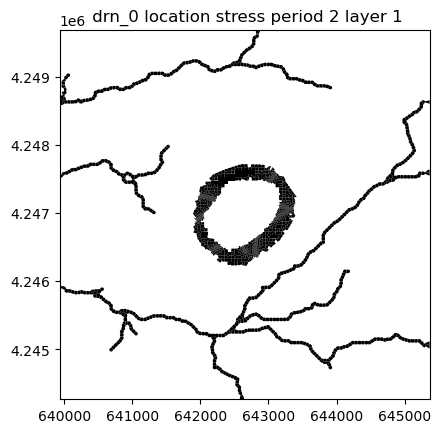

In [23]:
#river plot
drn.plot(mflay=0, kper=1) # <===== Inserted 

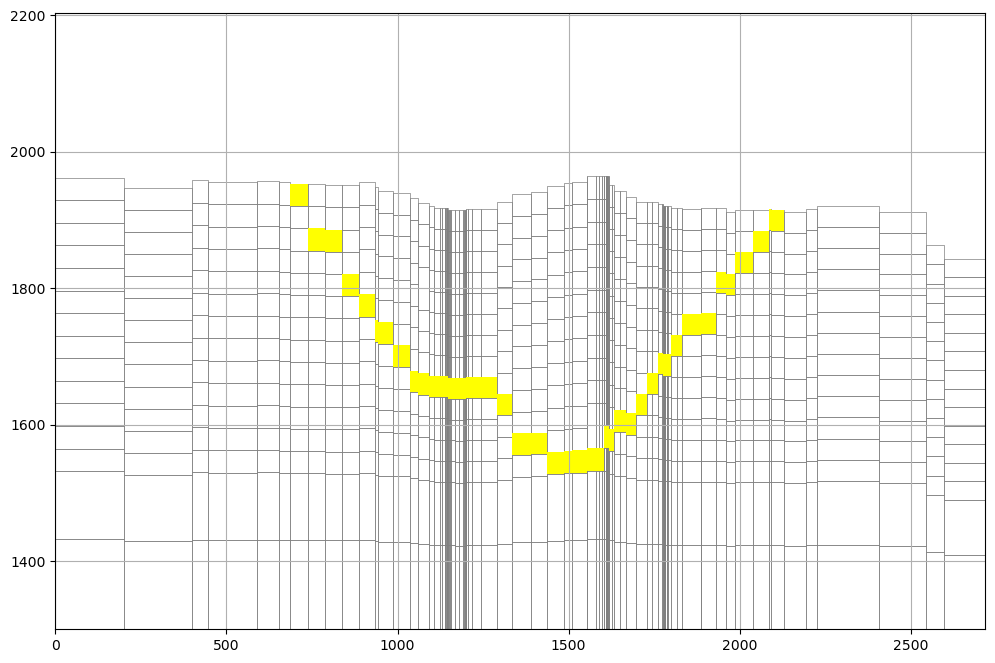

In [24]:
crossSection = gpd.read_file('../shp/crossSection.shp') ## Org
sectionLine =list(crossSection.iloc[0].geometry.coords) ## Org

fig, ax = plt.subplots(figsize=(12,8)) ## Org
xsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine}) ## Org
lc = xsect.plot_grid(lw=0.5) ## Org
xsect.plot_bc('DRN',kper=5) ## Org
ax.grid() ## Org

In [25]:
#regional flow package
from mf6Voronoi.tools.cellWork import getLayCellElevTupleFromRaster, getLayCellElevTupleFromElev

layCellTupleList, elevList = getLayCellElevTupleFromRaster(gwf,interIx,'../rst/waterTable.tif','../shp/local/regionalFlow.shp') ## <=== updated
ghbSpd = {} ## Org
ghbSpd[0] = [] ## Org
for index, layCellTuple in enumerate(layCellTupleList): ## <=== updated
    ghbSpd[0].append([layCellTuple,elevList[index],0.01]) ## <=== updated
ghbSpd[0][:5] ## <=== updated

The cell 184 has a elevation of 1769.58 outside the model vertical domain


[[(0, 0), np.float64(1778.0935269188267), 0.01],
 [(1, 3), np.float64(1783.1766687198597), 0.01],
 [(0, 6), np.float64(1769.62907148028), 0.01],
 [(1, 17), np.float64(1808.703641876546), 0.01],
 [(0, 18), np.float64(1779.3558072992978), 0.01]]

[<Axes: title={'center': ' ghb_0 location stress period 1 layer 1'}>]

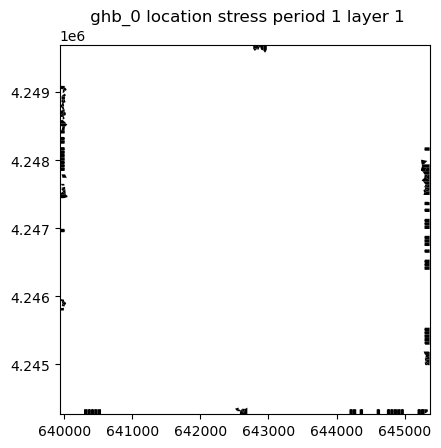

In [26]:
ghb = flopy.mf6.ModflowGwfghb(gwf, stress_period_data=ghbSpd) ## <===== modified
#regional flow plot
ghb.plot(mflay=0, kper=0) ## <===== modified

### Set the Output Control and run simulation

In [27]:
#oc
head_filerecord = f"{gwf.name}.hds" ## Org
oc = flopy.mf6.ModflowGwfoc(gwf, ## Org
                            head_filerecord=head_filerecord, ## Org
                            saverecord=[("HEAD", "LAST")]) ## Org

In [28]:
# Run the simulation
sim.write_simulation() ## Org
success, buff = sim.run_simulation() ## Org

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mf6Model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package evta_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 29349 based on size of stress_period_data
    writing package obs_0...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 462 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 12 2025 12:42:18 with Intel(R) Fortran Intel(R) 64
   

### Model output visualization

In [29]:
headObj = gwf.output.head() ## Org
headObj.get_kstpkper() ## Org

[(np.int32(0), np.int32(0)),
 (np.int32(0), np.int32(1)),
 (np.int32(0), np.int32(2)),
 (np.int32(0), np.int32(3)),
 (np.int32(0), np.int32(4)),
 (np.int32(0), np.int32(5))]

In [30]:
heads = headObj.get_data(kstpkper=(0,0)) 
np.save('../npy/headCalibInitial', heads)

In [31]:
kper = 5 ## Org
lay = 0 ## Org

In [32]:
heads = headObj.get_data(kstpkper=(0,5)) ## Org
heads2 = headObj.get_data(kstpkper=(0,5)) ## Org
#heads[lay,0,:5] 
#heads = headObj.get_data(kstpkper=(0,0)) 
#np.save('npy/headCalibInitial', heads)

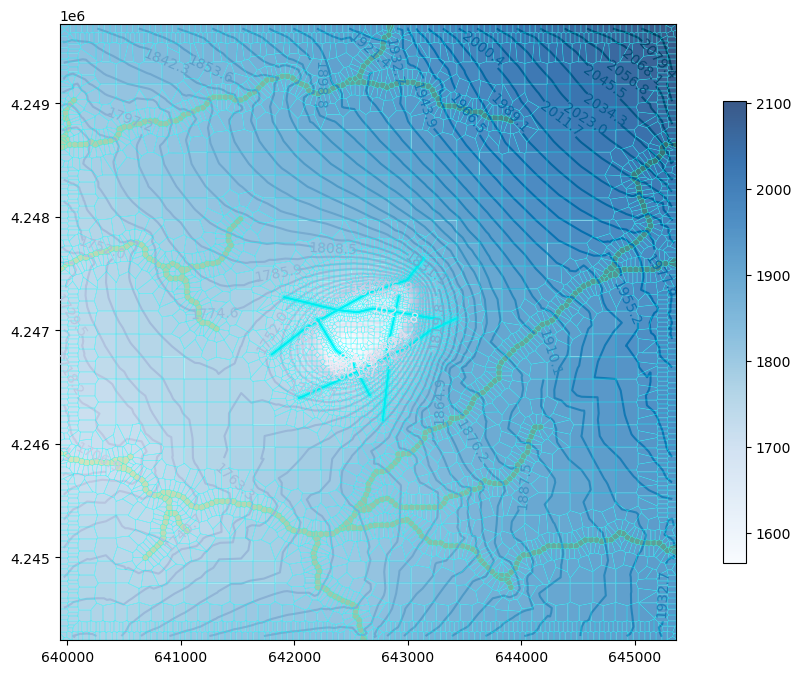

In [33]:
### Plot the heads for a defined layer and boundary conditions
fig = plt.figure(figsize=(12,8)) ## Org
ax = fig.add_subplot(1, 1, 1, aspect='equal') ## Org
modelmap = flopy.plot.PlotMapView(model=gwf) ## Org

####
levels = np.linspace(heads[heads>-1e+30].min(),heads[heads>-1e+30].max(),num=50) ## Org
contour = modelmap.contour_array(heads[lay],ax=ax,levels=levels,cmap='PuBu') ## Org
ax.clabel(contour) ## Org


quadmesh = modelmap.plot_bc('DRN') ## Org
cellhead = modelmap.plot_array(heads[lay],ax=ax, cmap='Blues', alpha=0.8) ## Org 

linecollection = modelmap.plot_grid(linewidth=0.3, alpha=0.5, color='cyan', ax=ax) ## Org

plt.colorbar(cellhead, shrink=0.75) ## Org

plt.show() ## Org

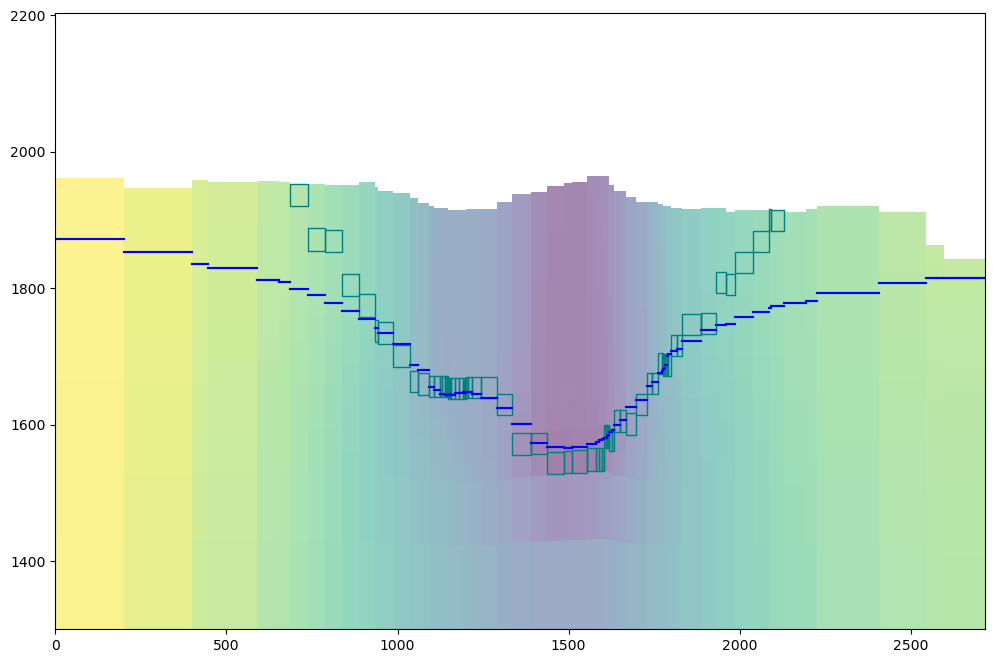

In [34]:
crossSection = gpd.read_file('../shp/crossSection.shp') ## Org
sectionLine =list(crossSection.iloc[0].geometry.coords) ## Org

waterTable = flopy.utils.postprocessing.get_water_table(heads) ## Org
waterTable2 = flopy.utils.postprocessing.get_water_table(heads2) ## Org

fig, ax = plt.subplots(figsize=(12,8)) ## Org
xsect = flopy.plot.PlotCrossSection(model=gwf, line={'Line': sectionLine}) ## Org
lc = modelxsect.plot_grid(lw=0.5) ## Org
xsect.plot_array(heads2, alpha=0.5) ## Org
xsect.plot_surface(waterTable) ## Org
xsect.plot_surface(waterTable2) ## Org
xsect.plot_bc('drn', kper=kper, facecolor='none', edgecolor='teal') ## Org
plt.show() ## Org